## **Exploración de Sentencias - Corte Constitucional**

## **Importación de librerías**

In [1]:
import nltk


# tokenizadores
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TweetTokenizer

# diccionarios especiales para puntuación y palabras vacias
nltk.download('punkt') # Manejo de puntuación
nltk.download('stopwords')

# wordnet
nltk.download('wordnet')

from nltk.corpus import stopwords

# lematizador basado en WordNet de nltk
from nltk.stem import WordNetLemmatizer 

# stemmer de nltk. Raiz de las palabras
#from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer 
import gensim
from gensim.parsing.preprocessing import STOPWORDS
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 


[nltk_data] Downloading package punkt to /home/caicardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caicardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/caicardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# manipulación de datos
import pandas as pd
import numpy as np

# conveniencias
from tqdm import tqdm
import os

# proceso de texto
import json
import re
import nltk
import spacy

# procesamiento paralelo
from multiprocessing import Pool

# machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from gensim.test.utils import datapath
from gensim.models import FastText

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# from tqdm.notebook import tnrange, tqdm_notebook, tqdm
from tqdm import tqdm

In [4]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [5]:
from gensim import corpora, models

In [6]:
nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caicardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Definición de funciones**

In [7]:
def preprocessor(text):
    """
    preprocesador de texto
    """
    if not isinstance(text, str):
        return ""
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~ºª'''
    for char in punctuations:
        text = text.replace(char, " ")
    
    text = re.sub("\s+", " ", text)
    text = text.strip().lower()
    text = re.sub("\d+", "<NUM>", text)
    return text

In [8]:
def preprocessor_sentences(text):
    """
    preprocesador de texto con separación de frases por línea.
    """
    if not isinstance(text, str):
        return ""
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~ºª'''
    for char in punctuations:
        text = text.replace(char, " ")
    text = re.sub("\d+", "<NUM>", text)
    text = text.replace("\n\n", "<FIN>")
    text = text.replace(".", "<FIN>")
    text = re.sub("\s+", " ", text)
    text = text.replace("<FIN>", "\n")
    text = "".join([c for c in text if str.isprintable(c) or c=="\n" or c=="."])
    text = re.sub("[\n\r]+", "\n", text)
    text = text.lower()
    text = text.strip("\n ")
    return text

In [9]:
def wv_vectorizer(text):
    """
    Calcula el vector promedio de las palabras de la frase.
    """
    text = preprocessor(text)
    vec_list = []
    for word in [w for w in text.split() if w not in es_stopwords]:
        vec_list.append(model.wv[word])
    vec_list = np.array(vec_list)
    vec = np.mean(vec_list, axis=0)
    return vec

In [10]:
def remove_stopwords(text):
    tokens = text.split()
    out = " ".join([word for word in tokens if word not in es_stopwords])
    return out

In [11]:
def lemmatize(text):
    nlp_tokens = nlp(text)
    lemma = [w.lemma_ for w in nlp_tokens]
    lemma = " ".join(lemma)
    return lemma
    

## **Configuración**

In [12]:
RANDOM_STATE = 42
N_TOP_DOCS = 5
CARACTERES = 500

In [13]:
DATA_PATH = './scrappy/'

In [14]:
es_stopwords = nltk.corpus.stopwords.words("spanish")

In [15]:
es_stopwords.remove("no")

In [16]:
es_stopwords.append("<NUM>")

## **Lectura de datos**

In [17]:
files = os.listdir(DATA_PATH)

df = pd.DataFrame()

for file in tqdm([f for f in files if f.endswith(".json")], leave=False):
    p_list = []
    
    if os.path.isfile(os.path.join(DATA_PATH, file)):
        with open(os.path.join(DATA_PATH, file), 'r') as f:
            data = json.load(f)
    else:
        continue
    
    doc_name = data["name"]
    doc_link = data["link"]
    
    for p in data["paragraphs"]:
        current_p = p
        current_p["name"] = doc_name
        current_p["link"] = doc_link
        p_list.append(current_p)
    
    df = df.append(p_list, ignore_index=True)
    break

In [22]:
df.head()

,p_index,tag,text,class,name,link
0,0,h5,Sentencia T-120/05,no_class,T-120-05,https://www.corteconstitucional.gov.co/Relator...
1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,[MsoNormal],T-120-05,https://www.corteconstitucional.gov.co/Relator...
2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,[MsoNormal],T-120-05,https://www.corteconstitucional.gov.co/Relator...
3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,[MsoNormal],T-120-05,https://www.corteconstitucional.gov.co/Relator...
4,9,p,Referencia: expediente T-992178,[MsoNormal],T-120-05,https://www.corteconstitucional.gov.co/Relator...


In [21]:
for i, t in df.iterrows():
    print(t.text, "\n")

Sentencia T-120/05 

PROPIEDAD HORIZONTAL-Obligaciones a cargo de los propietarios
de bienes privados/EXPENSAS COMUNES EN REGIMEN DE PROPIEDAD HORIZONTAL-Solidaridad
en su pago entre el propietario anterior y el nuevo propietario 

ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago cuotas de administración en
condominio 

CUOTAS DE ADMINISTRACION-Compra de inmueble en remate y que tenía
deuda por este concepto 

Referencia: expediente T-992178 

Acción de tutela de Edwin Yesid Rojas
Vargas contra Juzgado 14 Civil del Circuito de Bogotá. 

Procedencia: Corte Suprema de Justicia –
Sala de Casación Civil. 

Magistrado Ponente:  

Dr. ALFREDO BELTRÁN SIERRA 

Bogotá D.C., diecisiete (17) de febrero de dos mil
cinco (2005). 

La Sala Segunda de Revisión de la Corte Constitucional,
integrada por los magistrados Alfredo Beltrán Sierra, Manuel José Cepeda
Espinosa y Jaime Córdoba Triviño, en ejercicio de sus competencias
constitucionales y legales, ha proferido la siguiente 

SENTENCIA 

en el pro

In [16]:
len(df)

6587045

In [23]:
df["link"] = [x.replace("https://www.corteconstitucional.gov.co/", "") for x in df.link.values]

In [18]:
df.head()

,p_index,tag,text,class,name,link
0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm
1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,[MsoNormal],T-120-05,Relatoria/2005/T-120-05.htm
2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,[MsoNormal],T-120-05,Relatoria/2005/T-120-05.htm
3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,[MsoNormal],T-120-05,Relatoria/2005/T-120-05.htm
4,9,p,Referencia: expediente T-992178,[MsoNormal],T-120-05,Relatoria/2005/T-120-05.htm


In [23]:
df.to_csv("data/cc_dump_p.csv")

In [ ]:
df = pd.read_csv("data/cc_dump_p.csv")

In [20]:
len(df.name.unique())

34932

In [25]:
np.max([len(x.strip().split()) for x in df.text.values])

7456

In [21]:
df["class"] = [x[0] if isinstance(x, list) and len(x)==1 else x for x in df["class"].values]

In [22]:
df.head()

,p_index,tag,text,class,name,link
0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm
1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm
4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm


In [26]:
df["class"].value_counts

<bound method IndexOpsMixin.value_counts of 0                 no_class
1                MsoNormal
2                MsoNormal
3                MsoNormal
4                MsoNormal
                ...       
6587040    MsoFootnoteText
6587041    MsoFootnoteText
6587042    MsoFootnoteText
6587043    MsoFootnoteText
6587044    MsoFootnoteText
Name: class, Length: 6587045, dtype: object>

In [27]:
df["class"] = pd.Categorical(df["class"])

In [28]:
df["class"].value_counts()

MsoNormal           4551106
MsoFootnoteText      761740
MsoBodyText          235935
no_class             139539
MsoListParagraph      84890
                     ...   
ecxecxbodytext2           1
ecmsobodytext             1
decretos                  1
de                        1
yiv8754979524             1
Name: class, Length: 1357, dtype: int64

In [13]:
df = pd.read_csv("data/documents_V1_2/documents_V1_2.csv")

In [14]:
print(df.columns)

Index(['INDEX', 'DOCUMENT_TYPE', 'LINK', 'DOCUMENT', 'DOCUMENT_WITH_SIGNS',
       'DOCUMENT_CLEAN'],
      dtype='object')


In [15]:
df["tipo"] = [x.strip()[0] for x in df.INDEX]

In [16]:
df.head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo
0,A107-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10721\n \n \nreferencia: expediente t-7.9...,auto 10721 referencia: expediente t-7.909.170...,auto 10721 referencia expediente t 7 909 170 a...,A
1,A106-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10621\n \n \nreferencia: expediente t-6.8...,auto 10621 referencia: expediente t-6.839.494...,auto 10621 referencia expediente t 6 839 494 a...,A
2,A092-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09221\n \n \nreferencia: respuesta a la s...,auto 09221 referencia: respuesta a la solicit...,auto 09221 referencia respuesta a la solicitud...,A
3,A091-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09121\n \n \nreferencia: requerimiento al...,auto 09121 referencia: requerimiento al minis...,auto 09121 referencia requerimiento al ministr...,A
4,A090-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09021\n \n \nreferencia: expediente t- 7....,auto 09021 referencia: expediente t- 7.185.42...,auto 09021 referencia expediente t 7 185 421 a...,A


In [17]:
df.tipo.value_counts()

T    18804
A     8739
C     6543
S      391
Name: tipo, dtype: int64

## **Preprocesamiento de texto (para TF-IDF)**

No es necesario volver a preprocesar los datos, se deja el código para referencia y replicación

In [29]:
%%time
with Pool(8) as my_pool:
    pp_list = my_pool.map(preprocessor, df.text.values)

CPU times: user 10.3 s, sys: 7.35 s, total: 17.7 s
Wall time: 30.1 s


In [30]:
df["pp"] = pp_list

In [15]:
df.head()

,Unnamed: 0,p_index,tag,text,class,name,link,pp
0,0,0,h5,Sentencia T-120/05,no_class,T-120-05,Relatoria/2005/T-120-05.htm,sentencia t <NUM> <NUM>
1,1,2,p,PROPIEDAD HORIZONTAL-Obligaciones a cargo de l...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,propiedad horizontal obligaciones a cargo de l...
2,2,4,p,ADMINISTRACION DE PROPIEDAD HORIZONTAL-No pago...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,administracion de propiedad horizontal no pago...
3,3,6,p,CUOTAS DE ADMINISTRACION-Compra de inmueble en...,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,cuotas de administracion compra de inmueble en...
4,4,9,p,Referencia: expediente T-992178,MsoNormal,T-120-05,Relatoria/2005/T-120-05.htm,referencia expediente t <NUM>


**Guardar datos preprocesados**

In [32]:
df.to_csv("data/cc_dump_p_pp.csv")

In [14]:
df = pd.read_csv("data/cc_dump_p_pp.csv")

In [33]:
# Ejemplo
df.iloc[0].pp

'sentencia t <NUM> <NUM>'

In [34]:
remove_stopwords(df.iloc[0].pp)

'sentencia t'

In [35]:
%%time
lemmatize(remove_stopwords(df.iloc[0].pp))

CPU times: user 193 ms, sys: 3.41 ms, total: 196 ms
Wall time: 214 ms


'sentencia t'

In [29]:
df[df.text!=df.text]

,Unnamed: 0,p_index,tag,text,class,name,link,pp


In [30]:
df[df.pp==""]

,Unnamed: 0,p_index,tag,text,class,name,link,pp


In [25]:
df = df[df.pp!=""].copy()
df = df[df.text==df.text]

In [36]:
df[np.array([type(x) for x in df.pp.values])!=str]

,Unnamed: 0,p_index,tag,text,class,name,link,pp
597,597,95,p,(...),MsoNormal,C-381-00,Relatoria/2000/C-381-00.htm,NaN
1683,1683,42,p,"""..",MsoNormal,C-485-95,Relatoria/1995/C-485-95.htm,NaN
2812,2812,159,p,(...),MsoNormal,T-1207-08,Relatoria/2008/T-1207-08.htm,NaN
2831,2831,197,p,(...),MsoBodyText3,T-1207-08,Relatoria/2008/T-1207-08.htm,NaN
3589,3589,201,p,.\r\n. .,MsoNormal,T-420-96,Relatoria/1996/T-420-96.htm,NaN
...,...,...,...,...,...,...,...,...
6580192,6580192,556,p,- \r\n,MsoNormal,T-197-07,Relatoria/2007/T-197-07.htm,NaN
6582081,6582081,334,p,...,MsoNormal,C-086-93,Relatoria/1993/C-086-93.htm,NaN
6585163,6585163,732,p,(...),MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,NaN
6585299,6585299,957,p,(...),MsoNormal,C-753-08,Relatoria/2008/C-753-08.htm,NaN


In [40]:
df = df[np.array([type(x) for x in df.pp.values])==str].copy()

## LDA

In [41]:
df["char_len"] = [len(x) for x in df.pp.values]

In [42]:
df[df.char_len>1000000]

,Unnamed: 0,p_index,tag,text,class,name,link,pp,char_len


In [43]:
for i in df.link.head():
    print(i)

Relatoria/2005/T-120-05.htm
Relatoria/2005/T-120-05.htm
Relatoria/2005/T-120-05.htm
Relatoria/2005/T-120-05.htm
Relatoria/2005/T-120-05.htm


In [37]:
# df.LINK.to_csv("links.csv")

In [44]:
%%time
with Pool(8) as my_pool:
    print("stopwords")
    lemma_list = my_pool.map(remove_stopwords, df.pp.values)
    print("lemma")
    lemma_list = my_pool.map(lemmatize, lemma_list)

df["lemma_stop"] = lemma_list

stopwords
lemma
CPU times: user 19.7 s, sys: 28.6 s, total: 48.2 s
Wall time: 1h 22min 29s


In [45]:
df.to_csv("data/df_lemma.csv")

In [14]:
df = pd.read_csv("data/df_lemma.csv")

In [18]:
df[[isinstance(a, float) for a in df.lemma_stop.values]]

,Unnamed: 0,Unnamed: 0.1,p_index,tag,text,class,name,link,pp,char_len,lemma_stop
1855,1857,1857,26,p,Y,MsoNormal,C-366-94,Relatoria/1994/C-366-94.htm,y,1,NaN
1944,1946,1946,216,p,9.014,MsoNormal,C-366-94,Relatoria/1994/C-366-94.htm,<NUM> <NUM>,11,NaN
1945,1947,1947,217,p,2.644,MsoNormal,C-366-94,Relatoria/1994/C-366-94.htm,<NUM> <NUM>,11,NaN
1946,1948,1948,218,p,754,MsoNormal,C-366-94,Relatoria/1994/C-366-94.htm,<NUM>,5,NaN
1947,1949,1949,219,p,5,MsoNormal,C-366-94,Relatoria/1994/C-366-94.htm,<NUM>,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6571784,6586122,6586122,601,p,1239,MsoNormal,C-307-20,Relatoria/2020/C-307-20.htm,<NUM>,5,NaN
6571785,6586123,6586123,602,p,716,MsoNormal,C-307-20,Relatoria/2020/C-307-20.htm,<NUM>,5,NaN
6571786,6586124,6586124,603,p,608,MsoNormal,C-307-20,Relatoria/2020/C-307-20.htm,<NUM>,5,NaN
6571787,6586125,6586125,604,p,113,MsoNormal,C-307-20,Relatoria/2020/C-307-20.htm,<NUM>,5,NaN


In [19]:
df = df[[isinstance(a, str) for a in df.lemma_stop.values]]

In [20]:
df[df.lemma_stop.str.contains("\n")]

,Unnamed: 0,Unnamed: 0.1,p_index,tag,text,class,name,link,pp,char_len,lemma_stop


In [25]:
corpus_path = "cc_lemma_corpus.txt"

In [21]:
df.lemma_stop.to_csv(corpus_path, index=False, header=False)

In [29]:
df = None

In [24]:
class MyCorpus:
    def __init__(self, file_path: str, dictionary):
        self.dictionary = dictionary
        self.file_path = file_path
    def __iter__(self):
        for line in open(self.file_path):
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line.lower().strip().split())


In [30]:
cc_dict = corpora.Dictionary(line.lower().strip().split() for line in open(corpus_path))

In [31]:
len(cc_dict)

228302

In [32]:
cc_dict.filter_extremes(no_above=0.5, keep_n=200000)
cc_dict.compactify()  # remove gaps in id sequence after words that were removed

In [33]:
len(cc_dict)

83327

In [34]:
light_corpus = MyCorpus(corpus_path, cc_dict)

In [35]:
%%time
tfidf = models.TfidfModel(light_corpus)

CPU times: user 2min 2s, sys: 445 ms, total: 2min 2s
Wall time: 2min 3s


In [39]:
class TfidfCorpus:
    def __init__(self, corpus, model):
        self.corpus = corpus
        self.model = model
    def __iter__(self):
        for line in self.corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield self.model[line]


In [40]:
corpus_tfidf = TfidfCorpus(light_corpus, tfidf)

In [8]:
type([x.split() for x in df.pp.values])

list

In [46]:
df[df.pp.str.contains("0")]

,Unnamed: 0,p_index,tag,text,class,name,link,pp,char_len,lemma_stop


In [16]:
%%time
# Create a corpus from a list of texts
cc_tokens = [text.split() for text in df.pp.values]

CPU times: user 55 s, sys: 15.5 s, total: 1min 10s
Wall time: 1min 11s


In [18]:
df = None

In [19]:
%%time
cc_dict = Dictionary(cc_tokens)

CPU times: user 3min 46s, sys: 18.9 s, total: 4min 5s
Wall time: 4min 5s


In [21]:
# dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=100000)
cc_dict.filter_extremes(no_above=0.5, keep_n=200000)

In [22]:
len(cc_dict)

137334

In [23]:
def corpus_yielder(tokens, dictionary):
    for document in tokens:
        yield dictionary.doc2bow(document)

In [ ]:
# %%time
# cc_corpus = [cc_dict.doc2bow(text) for text in cc_tokens]

In [ ]:
# df.head()

In [26]:
def tfidf_yielder(corpus, model):
    for document in corpus:
        yield model[document]

In [ ]:
%%time
corpus_tfidf = tfidf[[x for x in corpus_yielder(cc_tokens, cc_dict)]]

In [ ]:
cc_tokens = None

In [42]:
%%time
# Train the model on the corpus.
lda = LdaMulticore(corpus_tfidf,
                   id2word=cc_dict,
                   num_topics=8,
                   workers=4,
#                    iterations=5,
#                    chunksize=24,
                   per_word_topics=True,
                   random_state=RANDOM_STATE,
                   passes=1)

CPU times: user 30min 47s, sys: 16.8 s, total: 31min 4s
Wall time: 31min 2s


In [27]:
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
frase = "Acceso a la salud del adulto mayor"

In [28]:
bow_busqueda = cc_dict.doc2bow(frase.split())
print(lda.get_document_topics(bow_busqueda))

[(0, 0.03125019), (1, 0.03125019), (2, 0.03125019), (3, 0.03125019), (4, 0.03125019), (5, 0.6981773), (6, 0.11432161), (7, 0.03125019)]


In [29]:
topn_words = {'Topic_' + str(i): [word for word, prob in lda.show_topic(i, topn=10)] for i in range(0, lda.num_topics)}

In [30]:
topn_words

{'Topic_0': ['de', 'la', '<NUM>', 'en', 'que', 'el', 'a', 'los', 'del', 'las'],
 'Topic_1': ['de', '<NUM>', 'en', 'la', 'el', 'que', 'y', 'las', 'por', 'a'],
 'Topic_2': ['de', 'la', 'en', '<NUM>', 'y', 'que', 'se', 'al', 'el', 'a'],
 'Topic_3': ['de', '<NUM>', 'la', 'que', 'en', 'lo', 'para', 'y', 'por', 'el'],
 'Topic_4': ['de', 'la', '<NUM>', 'en', 'que', 'del', 'el', 'a', 'y', 'los'],
 'Topic_5': ['de', 'la', '<NUM>', 'en', 'el', 'que', 'a', 'del', 'y', 'las'],
 'Topic_6': ['de', '<NUM>', 'la', 'en', 'que', 'el', 'los', 'a', 'y', 'las'],
 'Topic_7': ['de', 'la', '<NUM>', 'en', 'que', 'el', 'los', 'a', 'del', 'se']}

In [52]:
for i in range(8):
    print(i, lda.show_topic(i))

0 [('de', 0.0012239985), ('la', 0.0012239933), ('<NUM>', 0.0012239933), ('en', 0.0012239921), ('que', 0.0012239916), ('el', 0.0012239915), ('a', 0.0012239909), ('los', 0.0012239907), ('del', 0.0012239907), ('las', 0.0012239907)]
1 [('de', 0.0012239998), ('<NUM>', 0.0012239943), ('en', 0.0012239935), ('la', 0.0012239933), ('el', 0.0012239929), ('que', 0.0012239924), ('y', 0.0012239919), ('las', 0.0012239914), ('por', 0.0012239912), ('a', 0.0012239912)]
2 [('de', 0.0012239905), ('la', 0.0012239903), ('en', 0.0012239901), ('<NUM>', 0.0012239901), ('y', 0.00122399), ('que', 0.00122399), ('se', 0.00122399), ('al', 0.00122399), ('el', 0.00122399), ('a', 0.00122399)]
3 [('de', 0.0012239906), ('<NUM>', 0.0012239903), ('la', 0.0012239903), ('que', 0.0012239901), ('en', 0.0012239901), ('lo', 0.00122399), ('para', 0.00122399), ('y', 0.00122399), ('por', 0.00122399), ('el', 0.00122399)]
4 [('de', 0.001223993), ('la', 0.0012239916), ('<NUM>', 0.0012239907), ('en', 0.0012239906), ('que', 0.001223990

In [43]:
lda.print_topics(num_topics=8, num_words=10)

[(0,
  '0.005*"resolver" + 0.005*"derecho" + 0.004*"no" + 0.004*"público" + 0.004*"”" + 0.004*"“" + 0.004*"poder" + 0.004*"persona" + 0.003*"deber" + 0.003*"artículo"'),
 (1,
  '0.006*"día" + 0.006*"ministerio" + 0.005*"concreto" + 0.005*"nacional" + 0.005*"copia" + 0.005*"general" + 0.005*"caso" + 0.005*"secretario" + 0.004*"proyecto" + 0.004*"diciembre"'),
 (2,
  '0.105*"folio" + 0.073*"cuaderno" + 0.042*"secretaria" + 0.029*"instancia" + 0.029*"expediente" + 0.027*"ibídem" + 0.025*"general" + 0.021*"principal" + 0.020*"presidente" + 0.017*"decisión"'),
 (3,
  '0.013*"d" + 0.013*"expediente" + 0.013*"referencia" + 0.013*"bogotá" + 0.011*"victoria" + 0.010*"juzgado" + 0.009*"mil" + 0.009*"t" + 0.009*"circuito" + 0.008*"martho"'),
 (4,
  '0.008*"competencia" + 0.006*"no" + 0.006*"artículo" + 0.006*"corte" + 0.006*"constitucional" + 0.006*"ley" + 0.005*"norma" + 0.005*"él" + 0.004*"proceso" + 0.004*"judicial"'),
 (5,
  '0.038*"artículo" + 0.030*">" + 0.030*"<" + 0.030*"num" + 0.030*"aut

In [45]:
x=lda.show_topics(num_topics=8, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))


0::['resolver', 'derecho', 'no', 'público', '”', '“', 'poder', 'persona', 'deber', 'artículo']
1::['día', 'ministerio', 'concreto', 'nacional', 'copia', 'general', 'caso', 'secretario', 'proyecto', 'diciembre']
2::['folio', 'cuaderno', 'secretaria', 'instancia', 'expediente', 'ibídem', 'general', 'principal', 'presidente', 'decisión']
3::['d', 'expediente', 'referencia', 'bogotá', 'victoria', 'juzgado', 'mil', 't', 'circuito', 'martho']
4::['competencia', 'no', 'artículo', 'corte', 'constitucional', 'ley', 'norma', 'él', 'proceso', 'judicial']
5::['artículo', '>', '<', 'num', 'auto', 'antecedente', 'decreto', 'i', 'ley', 'constitucional']
6::['no', 'derecho', 'salud', 'pensión', 'acción', 'tutelar', 'fundamental', 'pago', 'laboral', 'entidad']
7::['magistrado', 't', 'sentencia', 'c', 'm', 'p', 'ponente', 'consideración', '…', 'corte']

resolver derecho no público ” “ poder persona deber artículo
día ministerio concreto nacional copia general caso secretario proyecto diciembre
folio cua

In [56]:
df[df.pp.str.contains("problema jurídico")|df.pp.str.contains("pregunta jurídica")]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp
52,A475-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 47520\n \n \nreferencia: expediente d-113...,auto 47520 referencia: expediente d-11306 dem...,auto 47520 referencia expediente d 11306 deman...,A,auto <NUM> referencia expediente d <NUM> deman...
58,A469-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 46920\n \n \nexpediente: d-13967\n \nasun...,auto 46920 expediente: d-13967 asunto: recurs...,auto 46920 expediente d 13967 asunto recurso d...,A,auto <NUM> expediente d <NUM> asunto recurso d...
84,A440-20,A,https://www.corteconstitucional.gov.co/Relator...,auto\r\n44020\n \n \nreferencia: expediente\r\...,auto 44020 referencia: expediente t-7785975 a...,auto 44020 referencia expediente t 7785975 acc...,A,auto <NUM> referencia expediente t <NUM> acció...
114,A406-20,A,https://www.corteconstitucional.gov.co/Relator...,auto\r\n40620\n \n \nexpediente: d-12329\n \nr...,auto 40620 expediente: d-12329 referencia: so...,auto 40620 expediente d 12329 referencia solic...,A,auto <NUM> expediente d <NUM> referencia solic...
118,A402-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 40220\n \n \nexpediente d-13808\n \nsolic...,auto 40220 expediente d-13808 solicitud de me...,auto 40220 expediente d 13808 solicitud de med...,A,auto <NUM> expediente d <NUM> solicitud de med...
...,...,...,...,...,...,...,...,...
34106,C-345-93,C,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia\r\nno. c-3...,sentencia no sentencia no. c-34593 cosa juzga...,sentencia no sentencia no c 34593 cosa juzgada...,C,sentencia no sentencia no c <NUM> cosa juzgada...
34242,C-005-93,C,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia\r\nc-00593...,sentencia no sentencia c-00593 juegos electron...,sentencia no sentencia c 00593 juegos electron...,C,sentencia no sentencia c <NUM> juegos electron...
34268,T-581-92,T,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia no.\r\nt-5...,sentencia no sentencia no. t-58192 derecho al ...,sentencia no sentencia no t 58192 derecho al t...,T,sentencia no sentencia no t <NUM> derecho al t...
34270,T-577-92,T,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia no.\r\nt-5...,sentencia no sentencia no. t-57792 banco de da...,sentencia no sentencia no t 57792 banco de dat...,T,sentencia no sentencia no t <NUM> banco de dat...


In [58]:
df.iloc[0].DOCUMENT.split("\n\n")

['auto 10721\n\xa0\n\xa0\nreferencia: expediente t-7.909.170 ac.\n\xa0\nacción\r\nde tutela promovida por carmen alicia rodríguez berrío y otros contra holding\r\ninmobiliaria y otros.\n\xa0\nasunto:\r\nsolicitud de\r\ncumplimiento de la sentencia t-020 de 2021.\n\xa0\npeticionaria:\r\ncarmen alicia rodríguez berrío.\n\xa0\nmagistrada\r\nsustanciadora:\ngloria\r\nstella ortiz delgado.\n\xa0\n\xa0\nbogotá,\r\nd.c., nueve (9) de marzo de dos mil veintiuno (2021).\n\xa0\n\xa0\nla\r\nsuscrita magistrada sustanciadora, en ejercicio de sus competencias\r\nconstitucionales y legales, profiere el presente auto con fundamento en los\r\nsiguientes:\nantecedentes\n\xa0\n1. el pasado 27 de enero, la sala\r\nsexta de revisión profirió la sentencia t-020 de 2021[1]. en el caso\r\nparticular de la señora carmen alicia, dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo\r\nvital. \n\xa0\n2. en consecuencia, esta corporación le ordenó a holding\r\ninmobi

## **Entrenamiento de vectores de palabras**

No es necesario entrenar el modelo con el corpus cada vez que se ejecute el libro, pasar a "cargar modelo"

**Prueba Segmentación por frases**

In [25]:
for i, frase in enumerate([frase for frase in preprocessor_sentences(df.iloc[0].DOCUMENT).split("\n")]):
    print("{0}. {1}".format(i, frase))

0. auto <num> referencia expediente t <num>
1. <num>
2. <num> ac
3.  acción de tutela promovida por carmen alicia rodríguez berrío y otros contra holding inmobiliaria y otros
4.  asunto solicitud de cumplimiento de la sentencia t <num> de <num>
5.  peticionaria carmen alicia rodríguez berrío
6.  magistrada sustanciadora gloria stella ortiz delgado
7.  bogotá d
8. c
9.  nueve <num> de marzo de dos mil veintiuno <num> 
10.  la suscrita magistrada sustanciadora en ejercicio de sus competencias constitucionales y legales profiere el presente auto con fundamento en los siguientes antecedentes <num>
11.  el pasado <num> de enero la sala sexta de revisión profirió la sentencia t <num> de <num> <num> 
12.  en el caso particular de la señora carmen alicia dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo vital
13.  <num>
14.  en consecuencia esta corporación le ordenó a holding inmobiliaria reintegrar a la peticionaria al trabajo que desempeñaba

**Guardar Corpus de documentos segmentados por frase**

In [24]:
with open("data/corpus/corpus_cc_v1.2.txt", "w") as file:
    for doc in df.DOCUMENT.values:
        file.write(preprocessor_sentences(doc))
        file.write("\n")

In [ ]:
carpeta = os.getcwd()
direccion_corpus = os.path.join(carpeta, 'corpus_cc.txt')

In [ ]:
corpus_file = datapath(direccion_corpus)         # absolute path to corpus
model = FastText(size=100, 
                 window=5, 
                 min_count=5, 
                 workers=-1, 
                 seed=RANDOM_STATE)
model.build_vocab(corpus_file=corpus_file)      # scan over corpus to build the vocabulary
total_words = model.corpus_total_words          # number of words in the corpus
model.train(corpus_file=corpus_file, total_words=total_words, epochs=5)

**Guardar modelo** 

In [78]:
model.save("modelo_cc.vec")

**Cargar modelo**

In [32]:
model = FastText.load("modelo_cc.vec")

## **Calcular vectores de las frases y los documentos**

**Entrenar vectores de documentos**

In [60]:
df = df[df.DOCUMENT==df.DOCUMENT].copy()

In [66]:
df["is_vec"] = [isinstance(x, np.ndarray) for x in df.vec.values]

In [68]:
df = df[df.is_vec].copy()

In [69]:
%%time
with Pool(8) as libreypool:
    vectors = libreypool.map(wv_vectorizer, df.pp.values)

df["vec"] = vectors

CPU times: user 659 ms, sys: 1.65 s, total: 2.31 s
Wall time: 3min 3s


In [70]:
doc_vectors = np.array([x for x in df.vec.values])
# doc_vectors = df.vec.values

**Guardar documentos con vectores**

In [16]:
df.to_csv("documents_vectors.csv")

**Cálculo de vector de la frase**

In [85]:
frase = "falsos positivos"

In [86]:
# calcular el vector de la frase
phrase_vec = wv_vectorizer(frase)

In [87]:
phrase_vec

array([-7.9891179e-04, -8.3545595e-04,  7.9064514e-05, -1.3889532e-04,
        7.7432662e-05, -9.4342715e-04,  8.5287174e-04, -1.5671623e-03,
       -3.0127165e-04,  5.8555260e-04,  1.4666485e-04, -5.9159973e-04,
        5.9816433e-04, -2.6181113e-04,  5.0692237e-04,  1.0184325e-04,
        1.4262067e-03,  1.0098720e-03,  1.1577185e-03, -1.2289413e-04,
        6.6517445e-04, -1.1912251e-03,  9.5556816e-04, -3.6705533e-04,
        1.1676630e-03, -4.8767758e-04,  1.1756071e-03,  6.2923471e-04,
        1.2166422e-03, -5.3517980e-04,  1.2296244e-03, -2.8679153e-04,
        1.8864045e-03, -3.0844501e-04,  2.9044930e-04,  1.0440049e-03,
        4.0050963e-04, -2.2457402e-04,  1.5262102e-03, -1.7055466e-03,
       -6.2408613e-04, -2.0565407e-03, -5.7985861e-04,  1.4982749e-03,
       -2.7552780e-04, -4.6384637e-04,  4.6858302e-04,  5.4883078e-04,
       -2.3545537e-04,  9.4649848e-04,  1.6477994e-04,  1.7281016e-04,
        1.3864455e-03,  4.8082497e-05, -2.1727444e-03,  5.0347362e-04,
      

In [88]:
# Calcular distancia de la frase a los documentos
distances = cosine_distances(phrase_vec.reshape(1, -1), doc_vectors)
# distances = cosine_distances(phrase_vec, doc_vectors)

In [89]:
distances = distances.flatten()

In [90]:
top_docs = np.argsort(distances, )[:N_TOP_DOCS]

In [91]:
for i, doc in enumerate(zip(df.iloc[top_docs].DOCUMENT, df.iloc[top_docs].INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

1.  T-340-09:
ii


sentencia
t-34009
 
licencia de maternidad-pago de licencia proporcionalmente a las semanas cotizadasderecho
al minimo vital de la madre y su hijo-pago de licencia de maternidad proporcionalmente
a las semanas cotizadaslicencia de maternidad-caso en que se ha
presentado interrupción de semanas de cotización
 
 referencia: expedientes t-2141913 y t-2141928 (acumulados).
                                               
acciones de
tutela instauradas por helen hernández holguín y edna juli
----------------------------------------------------------------------
2.  T-1273-05:
republica de colombia


sentencia t-127305
 
accion de tutela-procedencia excepcional para pago de sumas
de dinero originadas en contrato de prestación de servicios 
 
esta corporación ha señalado enfáticamente, en
relación con las obligaciones derivadas de relaciones contractuales o de
prestación de servicios que la acción de tutela no es un mecanismo jurídico
adecuado para reclamar derechos de carác

## **Búsqueda Literal**

In [116]:
busqueda = "ponente alejandro linares cantillo"

In [108]:
df["año"] = [x.split()[0].split("-")[-1] for x in df.INDEX.values]

In [118]:
AÑO_INICIO = 11
AÑO_FIN = 19
TIPO_SENTENCIA = 'S'

In [117]:
print("Total encontrados:", len(df[(df.pp.str.contains(busqueda.lower()))&(df.tipo==TI)&]))
print("-"*20)
df_tmp = df[(df.pp.str.contains(busqueda.lower()))&(df.tipo=='S')].head(N_TOP_DOCS)

for i, doc in enumerate(zip(df_tmp.DOCUMENT, df_tmp.INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

Total encontrados: 5
--------------------
1.  SU495-20:
sentencia su49520
 
 
referencia:
expediente t-7.783.646
 
acción de
tutela interpuesta por dorian jaime mejía galeano contra la
sala de definición de situaciones jurídicas y la sección de apelación del
tribunal para la paz de la jurisdicción especial para la paz. 
 
magistrado
ponente:
alejandro
linares cantillo
 
 
bogotá, d.c., veintisiete (27) de noviembre de dos mil
veinte (2020)
 
 
la sala plena de la corte constitucional, en ejercicio de
sus atribuciones constitucionales y de los
----------------------------------------------------------------------
2.  SU379-19:
nota de
relatoria: mediante auto
586 de fecha 29 de octubre de 2019, el cual se anexa a la presente providencia,
se aclara la orden proferida en el resolutivo tercero, en el sentido de indicar
que se deja sin efectos únicamente la decisión proferida dentro del proceso de pérdida
de investidura contra el señor álvaro escobar gonzález, en segunda instancia,
por la s

In [148]:
def get_ponente(text):
    if "magistrado ponente" not in text:
        return "N/A"
    indice = text.index("ponente")
    ponente = " ".join(text[indice:indice+200].split()[1:4])
    return ponente

In [149]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,cristina pardo schlesinger
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,diana fajardo rivera
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,de la libertad


In [150]:
df.tipo.value_counts()

T    18786
A     8737
C     6529
S      388
Name: tipo, dtype: int64

In [151]:
df["ponente"] = [get_ponente(text) if tipo!='A' else "N/A" for text, tipo in zip(df.pp.values, df.tipo.values)]

In [152]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,N/A
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,N/A
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,N/A


In [153]:
ponentes = df.ponente.value_counts().to_frame()

In [158]:
ponentes[(ponentes.ponente>5)]

,ponente
N/A,12120
dr alvaro tafur,998
dr marco gerardo,975
dr alfredo beltrán,964
dr rodrigo escobar,921
...,...
dr ciro angarita,6
fabio morón díaz,6
jaime araújo rentería,6
josé antonio cepeda,6


In [161]:
for i, (index, r) in enumerate(ponentes.iterrows()):
    print(i, index, r.ponente)

0 N/A 12120
1 dr alvaro tafur 998
2 dr marco gerardo 975
3 dr alfredo beltrán 964
4 dr rodrigo escobar 921
5 dr jaime córdoba 891
6 dr manuel josé 740
7 dr humberto antonio 705
8 mauricio gonzález cuervo 680
9 dr carlos gaviria 633
10 dr jaime araújo 616
11 dr jose gregorio 587
12 jorge ignacio pretelt 572
13 gabriel eduardo mendoza 566
14 luis guillermo guerrero 565
15 dr eduardo cifuentes 544
16 dr fabio moron 542
17 luis ernesto vargas 502
18 dr vladimiro naranjo 502
19 jorge iván palacio 470
20 dr nilson pinilla 469
21 dr antonio barrera 436
22 dr hernando herrera 421
23 alberto rojas ríos 415
24 dr alejandro martínez 378
25 dr jaime araujo 361
26 dr eduardo montealegre 355
27 dr josé gregorio 348
28 dr alejandro martinez 335
29 nilson pinilla pinilla 316
30 alejandro linares cantillo 290
31 dr jorge arango 273
32 dr manuel jose 247
33 humberto antonio sierra 230
34 carlos bernal pulido 197
35 dra clara inés 174
36 dr luis ernesto 169
37 alejandro martinez caballero 167
38 dr juan 

## **[EN CONSTRUCCIÓN] Análisis de frecuencia de palabras**

In [120]:
df["palabras"] = [len(doc.split()) for doc in df.pp.values]

In [121]:
import matplotlib.pyplot as plt

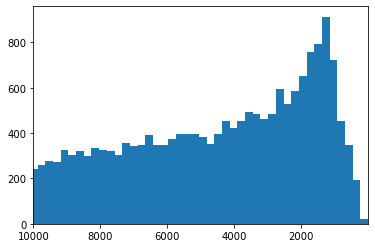

In [137]:
fig, ax = plt.subplots(1,1)
# fig.set_figheight(15)
# fig.set_figwidth(15)
# # ax.set_size_inches(10,15)
ax.set_xlim(10000)
ax.rev
ax.hist(df.palabras.values, bins=10000)

# data['pm2.5'].hist(bins=1000,grid=False)
# ax.set_xlabel("Palabras", fontsize=15)
# ax.set_ylabel("Documentos",fontsize=15)
plt.show()

In [139]:
np.argmax(df.palabras.values)

33328

In [145]:
print(df.iloc[np.argmax(df.palabras.values)].LINK)

https://www.corteconstitucional.gov.co/Relatoria/1996/C-037-96.htm


In [146]:
from bs4 import BeautifulSoup

In [148]:
main_soup = BeautifulSoup(df.iloc[np.argmax(df.palabras.values)].DOCUMENT, 'lxml')

In [149]:
main_soup.text

'LEY ESTATUTARIA JUSTICIA\n\n\n'

In [150]:
with open("sentencia_sucia.txt", "w") as f:
    f.write(df.iloc[np.argmax(df.palabras.values)].DOCUMENT)

In [35]:
X = ['mi mamá me mima', 'mi mamá me ama', 'amo a mi mamá']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vec = CountVectorizer(ngram_range=(1,3))
vec.fit(X)

CountVectorizer(ngram_range=(1, 3))

In [39]:
vec.vocabulary_

{'mi': 11,
 'mamá': 4,
 'me': 8,
 'mima': 14,
 'mi mamá': 12,
 'mamá me': 5,
 'me mima': 10,
 'mi mamá me': 13,
 'mamá me mima': 7,
 'ama': 0,
 'me ama': 9,
 'mamá me ama': 6,
 'amo': 1,
 'amo mi': 2,
 'amo mi mamá': 3}